#**Lets Play Hangman**

#Importing dependencies

In [34]:
import numpy as np
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt

The vocabulary:-

In [ ]:
vocab = np.array(list(" abcdefghijklmnopqrstuvwxyz_")) #here just for reference, used much later not now

#Data Preprocessing

In [6]:
def encode_word(word):
    """
    Encodes a word into a sequence of integers representing its letters' positions in the alphabet.

    Parameters:
    - word (str): The word to be encoded.

    Returns:
    - encoded_word (numpy.ndarray): An array of integers representing the positions of letters in the alphabet.

    Example:
    >>> encode_word('hello')
    array([ 8,  5, 12, 12, 15])
    """
    word = word.lower()
    encoded_word = np.frombuffer(word.encode('utf-8'), dtype=np.uint8)
    encoded_word = encoded_word.copy()
    encoded_word -= ord('a')
    encoded_word += 1

    return encoded_word.astype(int)

In [7]:
def mask_word(word, intensity):
    """
    Masks a word by replacing a certain number of its letters with a special token.

    Parameters:
    - word (numpy.ndarray): An array representing the word to be masked.
    - intensity (int): The number of letters to be masked in the word.

    Returns:
    - masked_word (numpy.ndarray): An array representing the masked word with certain letters replaced by a special token.
    - true_labels (numpy.ndarray): An array representing the true labels of the masked letters in one-hot encoded format.

    Example:
    >>> mask_word(np.array(['h', 'e', 'l', 'l', 'o']), 2)
    (array([27, 27, 12, 12, 15]), array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
    """
    word_copy = word.copy()
    letters_to_mask = np.random.choice(np.unique(word_copy), size=intensity, replace=False)
    pos = np.where(np.isin(word_copy, letters_to_mask))
    word_copy[pos] = 27
    true_labels = np.zeros((26,)).astype(int)
    true_labels[word[pos]-1] = 1

    return word_copy, true_labels

In [8]:
def pad_word(word, max_len):
    """
    Pads a word with zero padding to match a specified maximum length.

    Parameters:
    - word (numpy.ndarray): An array representing the word to be padded.
    - max_len (int): The maximum length of the padded word.

    Returns:
    - padded_word (numpy.ndarray): An array representing the padded word with zero padding added to match the maximum length.

    Example:
    >>> pad_word(np.array([8, 5, 12]), 7)
    array([ 8,  5, 12,  0,  0,  0,  0])
    """
    zero_padding = np.zeros((max_len - len(word)))
    padded_word = np.concatenate((word, zero_padding))

    return padded_word.astype(int)

In [9]:
def generate_previously_guessed_letters(word, masked_word):
    """
    Generates a binary array indicating which letters have been previously guessed.

    Parameters:
    - word (numpy.ndarray): An array representing the original word.
    - masked_word (numpy.ndarray): An array representing the masked word with certain letters replaced by a special token.

    Returns:
    - previously_guessed_letters (numpy.ndarray): A binary array indicating which letters have been previously guessed (1 for guessed, 0 for not guessed).

    Example:
    >>> generate_previously_guessed_letters(np.array([8, 5, 12]), np.array([27, 27, 12]))
    array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    """
    unique_characters = len(set(word))
    n = 26 - unique_characters
    count_27 = np.count_nonzero(masked_word == 27)
    std_dev = n / (5*count_27) if count_27 > 0 else 0
    random_integers = np.random.normal(0, std_dev)
    misses = np.clip(random_integers, 0, n).astype(int)
    pool = np.setdiff1d(np.arange(26), list(map(lambda x: x - 1, word)))
    random.shuffle(pool)
    previously_guessed_letters = np.zeros((26,))
    previously_guessed_letters[pool[:misses]] = 1
    masked_word_indices = masked_word[masked_word < 27] - 1
    previously_guessed_letters[masked_word_indices] = 1

    return previously_guessed_letters


In [10]:
def end_to_end_encoding_one_word_once(word, max_len, intensity):
    """
    Combines all functions defined above.

    Parameters:
    - word (str): The word to be encoded.
    - max_len (int): The maximum length to which the word will be padded.
    - intensity (int): The intensity of masking, i.e., the number of letters to be masked in the word.

    Returns:
    - padded_masked_word (numpy.ndarray): An array representing the padded and masked word.
    - previously_guessed_letters (numpy.ndarray): A binary array indicating which letters have been previously guessed.
    - true_labels (numpy.ndarray): An array representing the true labels of the masked letters in one-hot encoded format.

    Example:
    >>> end_to_end_encoding_one_word_once('hello', 7, 2)
    (array([27, 27, 12, 12, 15,  0,  0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
    """

    true_len = len(word)
    encoded_word = encode_word(word)
    print(encoded_word)
    masked_word, true_labels = mask_word(encoded_word, intensity=intensity)
    padded_masked_word = pad_word(masked_word, max_len)
    previously_guessed_letters = generate_previously_guessed_letters(encoded_word,masked_word)

    return padded_masked_word, previously_guessed_letters, true_labels

In [11]:
end_to_end_encoding_one_word_once("aditya", 10, 5)

[ 1  4  9 20 25  1]


(array([27, 27, 27, 27, 27, 27,  0,  0,  0,  0]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0]))

In [12]:
def end_to_end_encoding_whole_dataset(fileName):
    """
    Utilizes end_to_end_encoding_one_word_once defined above to generate the entire dataset.

    Parameters:
    - fileName (str): The name of the file containing the dataset of words.

    Returns:
    - X1 (numpy.ndarray): An array representing the padded and masked words.
    - X2 (numpy.ndarray): An array representing the binary arrays indicating which letters have been previously guessed for each word.
    - y (numpy.ndarray): An array representing the true labels of the masked letters in one-hot encoded format for each word.
    """
    path = os.path.join('/content',fileName)
    with open(path, 'r') as f:
      words = [line.strip().lower() for line in f]
    # words = np.random.permutation(words)

    global MAX_LEN
    MAX_LEN = max([len(i) for i in words])
    X1, X2, y = [], [], []

    for word in words:
      for intensity in range(len(set(word)),0,-1):
        x1_one, x2_one, y_one = end_to_end_encoding_one_word_once(word, max_len=MAX_LEN, intensity=intensity)
        X1.append(x1_one)
        X2.append(x2_one)
        y.append(y_one)

    return np.array(X1), np.array(X2), np.array(y)

#Helper Functions to Play Hangman

In [13]:
def cpu_play_hangman(model, true_word, max_len_fine_tune=20, verbose=False,):
  previous_guesses = np.zeros((1,26))
  # word_len = len(true_word)
  answer = np.zeros((1,len(true_word))).astype(int)
  answer[:,:] = 27
  incorrect_count = 0
  previous_guesses_train_data = []
  true_labels_train_data = []
  answer_train_data = []
  while(27 in answer[0,:]):
    answer_train_data.extend(np.expand_dims(pad_word(answer.copy()[0,:], max_len_fine_tune),0))
    previous_guesses_train_data.extend(previous_guesses.copy())
    true_labels = np.zeros((1,26))
    true_labels[0,:][np.setdiff1d(true_word, answer[0,:])-1] = 1
    true_labels_train_data.extend(true_labels.copy())
    prediction = model.predict([answer, previous_guesses], verbose=False)
    ai_guess = np.argmax(prediction)
    sorted_indexes = np.argsort(-prediction[0,:])
    index = 0
    while((ai_guess) in np.arange(26)[previous_guesses[0,:]==1] and index!=26):
      ai_guess = sorted_indexes[index]
      index += 1
      # print("i'm here with index:", index)
    pos = true_word==(ai_guess+1)
    previous_guesses[:, ai_guess] = 1
    # true_labels_train_data.extend()
    if(True not in pos):
      incorrect_count += 1
    else:
      answer[:, pos] = ai_guess + 1
    if(verbose == True):
      print("guess:", vocab[ai_guess+1])
      print("word:", ''.join(vocab[answer[0,:]]))
      # print("answer_train_data", answer_train_data)
      print()
  return incorrect_count, answer_train_data, previous_guesses_train_data, true_labels_train_data

In [107]:
def user_play_hangman(model):
  previous_guesses = np.zeros((1,26))
  user_word_len = int(input("input number of letters in your word: "))
  masked_word = np.zeros((1, user_word_len)).astype(int)
  masked_word[:,:] = 27
  incorrect_count = 0
  print(masked_word[0,:])
  while(27 in masked_word[0,:]):
    prediction = model.predict([masked_word, previous_guesses], verbose=False)
    # print("prediction:",prediction)
    ai_guess = np.argmax(prediction)
    pos = input(f"enter position for {vocab[ai_guess+1]}:")
    previous_guesses[:,ai_guess] = 1
    if(pos != 'x'):
      pos = list(map(int,pos.split()))
      masked_word[:,pos] = ai_guess + 1
    if(pos == 'x'):
      incorrect_count += 1
    # print("guess:", )
    print("word:", ''.join(vocab[masked_word[0,:]]))
    # print("guessed:", vocab[np.concatenate(([0],previous_guesses[0],[0]))==1])
  print("incorrect_count:",incorrect_count)

#Mount Google Drive to:-
1. Load Data
2. Store Models
3. Load these stored models

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Generate the Dataset

In [ ]:
X1, X2, y = end_to_end_encoding_whole_dataset('Hangman Word List.txt')

###Store the Dataset in Google Drive

In [ ]:
np.save('/content/drive/My Drive/hangman/X1_v2.npy', X1)
np.save('/content/drive/My Drive/hangman/X2_v2.npy', X2)
np.save('/content/drive/My Drive/hangman/y_v2.npy', y)

###Load Generated Dataset

In [15]:
X1 = np.load('/content/drive/My Drive/hangman/X1_v2.npy')
X2 = np.load('/content/drive/My Drive/hangman/X2_v2.npy')
y = np.load('/content/drive/My Drive/hangman/y_v2.npy')

In [16]:
print(''.join(vocab[X1[11]]))
print(vocab[np.concatenate(([0],y[11],[0]))==1])

___                          
['a' 'g']


##Shuffle and Partition Dataset

In [17]:
def mcshbap(X1, X2, y):

  #MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
  dataset = tf.data.Dataset.from_tensor_slices(((X1,X2), y))
  dataset = dataset.cache()
  dataset = dataset.shuffle(len(X1))
  dataset = dataset.batch(32)
  dataset = dataset.prefetch(16) # helps bottlenecks
  train = dataset.take(int(len(dataset)*.7))
  val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
  test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

  return train, test, val

MAX_LEN stores the length of the longest word in dataset

In [18]:
MAX_LEN = max([len(i) for i in X1])

#Model Architecture
The model takes two inputs:
1. The masked work for which guess needs to be made
2. The letters previously guessed by the model

The first input goes through 2 bidirectional lstm layers

The second input is simply connected to some fully connected dense layers

Their outputs are then concatenated and fed to dense layers with 26 output neurons, each one representing the 26 respective letters in the alphabet.

In [16]:
from tensorflow.keras.layers import LSTM, Embedding, Input, Dense, GlobalAveragePooling1D, Concatenate,Bidirectional
from tensorflow.keras.models import Model

inp_masked_word = Input(shape = (None,))
x1 = Embedding(30,100, mask_zero = True)(inp_masked_word)
x1 = Bidirectional(LSTM(100 , dropout = 0.2, return_sequences=True))(x1)
x1 = Bidirectional(LSTM(100, dropout = 0.2 , return_sequences=True))(x1)
x1 = GlobalAveragePooling1D()(x1)
x1 = Dense(100, activation = 'tanh')(x1)

inp_prev_guessed_letters = Input(shape = (26,))
x2 = Dense(60, activation = 'tanh')(inp_prev_guessed_letters)
x2 = Dense(60, activation = 'tanh')(x2)

x = Concatenate()([x1, x2])
x = Dense(100, activation = 'tanh')(x)
x = Dense(26, activation = 'softmax')(x)

model = Model(inputs=[inp_masked_word, inp_prev_guessed_letters],
                       outputs=x)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 100)            3000      ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, None, 200)            160800    ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, None, 200)            240800    ['bidirectional[0][0]']   

###Compiling the Model

- We could've used the binary cross entropy loss, which would treat the problem as a multi label classification problem, in which the masked word has multiple correct characters that could be picked.

* This is how I had trained the model first, in a previous notebook (hangman_v2).

* But here, I've set the loss to categorical cross entropy, now treating the problem as a masked word having one best response.

* To achieve this, the letters that need to be guessed are set to have equal probabilities (alternatively, we could've set the probability distribution to vary proportional to the frequency of each letter in the word).

In either case, during prediction, we pick the highest probability node from the 26d output layer and use it as the guessed letter.

In [19]:
# each entry in y needs to sum to one because we're using categorical cross entropy loss
y_normalized = y/np.expand_dims(np.sum(y, axis =1), axis=1)
print(y[2])
print(y_normalized[2])

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.5 0.  0.  0.  0.  0.  0.  0. ]


In [19]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(1e-3, clipnorm=1))

Checking for bugs

In [20]:
aditya_encoded, previous_guesses, _ = end_to_end_encoding_one_word_once('aditya',10,2)
print(previous_guesses)
print(aditya_encoded.shape)
model.predict([np.expand_dims(aditya_encoded,0), np.expand_dims(previous_guesses,0)])

[ 1  4  9 20 25  1]
[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0.]
(10,)
1/1 [==============================] - 6s 6s/step


array([[0.04487068, 0.05260931, 0.0416332 , 0.04260204, 0.04731336,
        0.03744285, 0.02887094, 0.03380676, 0.02498462, 0.03640433,
        0.03730086, 0.04651736, 0.04113194, 0.04146351, 0.03561266,
        0.03532149, 0.03334032, 0.03576597, 0.03492651, 0.03872498,
        0.04410335, 0.03919568, 0.03492558, 0.03140118, 0.05005854,
        0.02967194]], dtype=float32)

Splitting into train, test and validation sets

In [21]:
train, val, test = mcshbap(X1, X2, y_normalized)

##Fitting the model to our dataset
The model runs for 5 epochs in total

In [22]:
history1 = model.fit(train, epochs=2, validation_data=val)

Epoch 1/2
36776/36776 [==============================] - 930s 25ms/step - loss: 2.5471 - val_loss: 2.4793
Epoch 2/2
36776/36776 [==============================] - 888s 24ms/step - loss: 2.4649 - val_loss: 2.4346


In [23]:
model.save('hangman_v3_epoch2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
history2 = model.fit(train, epochs=2, validation_data=val)

Epoch 1/2
36776/36776 [==============================] - 884s 24ms/step - loss: 2.4357 - val_loss: 2.4072
Epoch 2/2
36776/36776 [==============================] - 900s 24ms/step - loss: 2.4196 - val_loss: 2.3967


In [26]:
model.save('hangman_v3_epoch4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
history3 = model.fit(train, epochs=1, validation_data=val)

36776/36776 [==============================] - 888s 24ms/step - loss: 2.4096 - val_loss: 2.3836


saving the model to gdrive

In [28]:
model.save('hangman_v3_epoch5.h5')

loading the model from gdrive

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/hangman/hangman_v3_epoch5.h5')

##Plotting Loss Function Graph

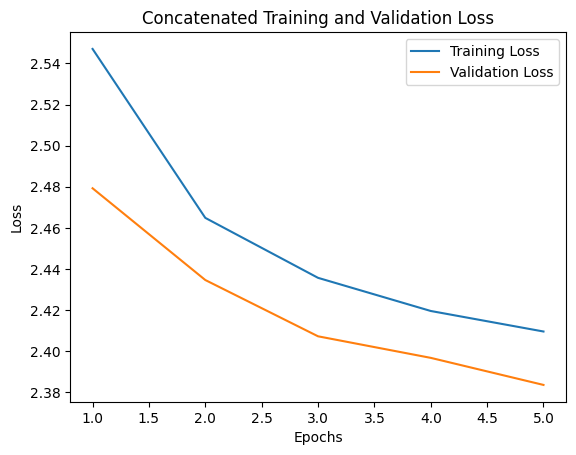

In [31]:
import matplotlib.pyplot as plt
# Concatenate multiple history objects into a single history object
def concatenate_histories(histories):
    concatenated_history = {"loss": [], "val_loss": []}

    for history in histories:
        concatenated_history["loss"].extend(history.history["loss"])
        concatenated_history["val_loss"].extend(history.history["val_loss"])

    return concatenated_history

histories = [history1, history2, history3]

concatenated_history = concatenate_histories(histories)

epochs = range(1, len(concatenated_history["loss"]) + 1)
plt.plot(epochs, concatenated_history["loss"], label='Training Loss')
plt.plot(epochs, concatenated_history["val_loss"], label='Validation Loss')
plt.title('Concatenated Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Testing the Model
Now we run the model on a randomly shuffled word list to test out it's accuracy and also get more data for training based on what the model gets wrong in case we want to fine tune it later (not done in this notebook)

In [2]:
with open('/content/hangman_word_list_shuffled.txt','r') as f:
  words = [word.strip().lower() for word in f.readlines()]

###Function to get the number of incorrect counts and new data for fine tuning

In [71]:
def test_and_gen_data(model, word_start_index, word_end_index):
  test_set = words[word_start_index:word_end_index]
  # print(encode_word(test_set[0]))
  misses, word_len, X1, X2, y = [], [], [], [], []
  max_len_fine_tune = MAX_LEN
  i = 0
  for word in test_set:
    word_len.append(len(word))
    misses_one, x1_one, x2_one, y_one = cpu_play_hangman(model, encode_word(word), max_len_fine_tune=max_len_fine_tune)
    misses.append(misses_one)
    X1.extend(x1_one)
    X2.extend(x2_one)
    y.extend(y_one)
    i+=1
    print(i, end=" ")
  # accuracy = [cpu_play_hangman(encode_word(word)) for word in test_set]
  X1 = np.array(X1)
  X2 = np.array(X2)
  y = np.array(y)
  misses = np.array(misses)
  print(misses)
  print(X1.shape)
  print(X2.shape)
  print(y.shape)
  np.save(f'/content/X1_v3_{str(word_start_index)[0]}k_{str(word_end_index)[0]}k.npy', X1)
  np.save(f'/content/X2_v3_{str(word_start_index)[0]}k_{str(word_end_index)[0]}k.npy', X2)
  np.save(f'/content/y_v3_{str(word_start_index)[0]}k_{str(word_end_index)[0]}k.npy', y)
  return misses, word_len, X1, X2, y

In [32]:
misses_1k, word_len_1k, X1_1k, X2_1k, y_1k = test_and_gen_data(model, 0, 1000)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [102]:
misses_2k, word_len_2k, X1_2k, X2_2k, y_2k = test_and_gen_data(model, 1000, 2000)

Concatenating the matrices we got above to get data for 2000 random words

In [91]:
misses_0k_2k = np.concatenate((misses_1k, misses_2k))
word_len_0k_2k = np.concatenate((word_len_1k, word_len_2k))
X1_0k_2k = np.concatenate((X1_1k, X1_2k))
X2_0k_2k = np.concatenate((X2_1k, X2_2k))
y_0k_2k = np.concatenate((y_1k, y_2k))


Saving to upload to gdrive

In [109]:
np.save('/content/misses_v3_0k_2k.npy', misses_0k_2k)
np.save('/content/word_len_v3_0k_2k.npy', word_len_0k_2k)
np.save('/content/X1_v3_0k_2k.npy', X1_0k_2k)
np.save('/content/X2_v3_0k_2k.npy', X2_0k_2k)
np.save('/content/y_v3_0k_2k.npy', y_0k_2k)

#Assessing Model Performance

###Histogram to analyze the number of incorrect guesses made by the model

Text(0, 0.5, 'Number of Words')

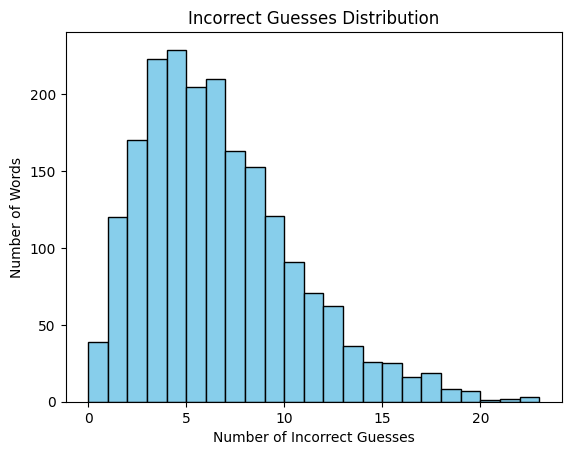

In [97]:
plt.hist(misses_0k_2k, bins=max(misses_0k_2k), color='skyblue', edgecolor='black')
plt.title('Incorrect Guesses Distribution')
plt.xlabel('Number of Incorrect Guesses')
plt.ylabel('Number of Words')


##Plotting correlation between:
+ length of the word
+ incorrect guesses made to before fully guessing the word


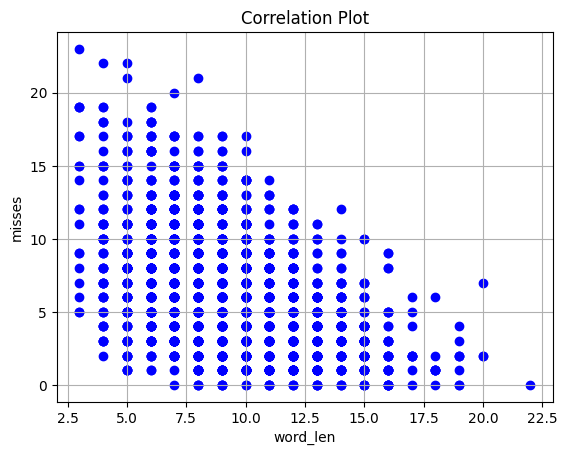

In [93]:
plt.scatter(word_len_0k_2k, misses_0k_2k, color='blue')
plt.title('Correlation Plot')
plt.xlabel('word_len')
plt.ylabel('misses')
plt.grid(True)
plt.show()


As expected, the number of incorrect guesses is most when the word has very few letters.

#Testing Accuracy of the Model
If have 6 lives, then the model correctly guesses ~60% of the words fully.

In [101]:
accuracy = np.sum(np.ones(2000)[misses_0k_2k<=6])/np.sum(np.ones(2000))
print("accuracy:",accuracy)

accuracy: 0.598


#Playing the Game!
+ With the function **user_play_hangman** we can have full control of the gameplay, in which we don't have to provide the correct answer to the program and just observe how it plays.
+ Alternatively, with the function **cpu_play_hangman**, we can just give a word to the program and it will play the game for us.



In [108]:
# input space separated indices for position of the letter in the word
# if the letter does not exist in the word, input x
user_play_hangman(model)

input number of letters in your word: 7
[27 27 27 27 27 27 27]
enter position for a:1 5
word: _a___a_
enter position for r:x
word: _a___a_
enter position for m:4
word: _a__ma_
enter position for n:2 6
word: _an_man
enter position for t:x
word: _an_man
enter position for h:0
word: han_man
enter position for d:x
word: han_man
enter position for g:3
word: hangman
incorrect_count: 3


In [103]:
misses_terminator,_,_,_ = cpu_play_hangman(model, encode_word('terminator'),verbose=True, max_len_fine_tune=MAX_LEN)
print("no of incorrect guesses for the word terminator:", misses_terminator)

guess: a
word: ______a___

guess: e
word: _e____a___

guess: i
word: _e__i_a___

guess: l
word: _e__i_a___

guess: r
word: _er_i_a__r

guess: t
word: ter_i_at_r

guess: o
word: ter_i_ator

guess: m
word: termi_ator

guess: n
word: terminator

no of incorrect guesses for the word terminator: 1
